# CMU Movie data

In [59]:
import pandas as pd
import numpy as np
import re
import json
import os

from src.data_completion import *
from src.data_preprocessing import *
from src.data_loading import *
from src.data_fetching import *
from src.data_visualization import *

import statsmodels.formula.api as smf

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download datasets
The following code downloads the datasets that were too heavy to be included, and places them directly in the `data` folder.

In [60]:
# Download TMDb Dataset
download_tmdb()

# Download IMDb Dataset
download_imdb("name.basics.tsv")
download_imdb("title.ratings.tsv")
download_imdb("title.principals.tsv")

# Download CMU dataset
download_cmu()

TMDb dataset already exists. Skipping download.
name.basics.tsv already exists. Skipping download.
title.ratings.tsv already exists. Skipping download.
title.principals.tsv already exists. Skipping download.
All required files of CMU are already present. Skipping download.


## Initial data inspection
We begin by providing a first generic inspection of the CMU movie dataset we decided to work on.

### Load Data
The dataset is divided into 3 parts, the characters, the movies and the plots of the movies.

In [61]:
character_data, movie_data, plot_data = load_data()

### Characters dataset
Let's first have a look at the character dataset.

In [62]:
print(f'There are {character_data.shape[0]} characters with {character_data.shape[1]} features for each.')

There are 450669 characters with 13 features for each.


In [63]:
character_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


We directly note that the actor ethnicities are not human readable, they seem to be freebase ids. It's something we will need to fix during preprocessing.
Let's now see how much missing data we have.

In [64]:
print("Percentage of null rows in the characters dataset for each features:")
print(character_data.isnull().mean().round(3)*100)

Percentage of null rows in the characters dataset for each features:
wikipedia_movie_id         0.0
freebase_movie_id          0.0
movie_release_date         2.2
character_name            57.2
actor_dob                 23.6
actor_gender              10.1
actor_height              65.6
actor_ethnicity           76.5
actor_name                 0.3
actor_age_at_release      35.1
character_actor_map_id     0.0
character_id              57.2
actor_id                   0.2
dtype: float64


We see that we miss a lot of character names/ids, actor heights, ethnicity and age at release. We can also check for duplicate rows.

In [65]:
print(f"Duplicated rows: {character_data.duplicated().sum()}")

Duplicated rows: 0


### Movies dataset
Let's now have a look at the movies dataset.

In [66]:
print(f'There are {movie_data.shape[0]} movies with {movie_data.shape[1]} features for each.')

There are 81741 movies with 9 features for each.


In [67]:
movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


Let's now see if we have a lot of missing data. We will also verify that we don't have duplicated rows.

In [68]:
print("Percentage of null rows in the movies dataset for each features:")
print(movie_data.isnull().mean().round(3)*100)

Percentage of null rows in the movies dataset for each features:
wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     8.4
box_office_revenue    89.7
runtime               25.0
languages              0.0
countries              0.0
genres                 0.0
dtype: float64


In [69]:
print(f"Duplicated rows: {movie_data.duplicated().sum()}")

Duplicated rows: 0


Ouch! We only have box office revenue for 10% of our movies, that's not good news since it's a key feature in our research problematic, we will need to fix this. Apart from this, we can also note that we are missing 25% of the runtime information. We could try to improve this. This also applies to the movie release data. For the languages, countries and genres, we note that they are dictionaries meaning that we first need to preprocess them a bit (for example transforming them to a list) to then be able to see the percentage of missing data. We will do it now:

In [70]:
# Extract the readable values for 'languages', 'countries', and 'genres' columns. Also clean the language column.

movie_data['languages'] = movie_data['languages'].apply(lambda x: extract_values(x, clean_func=clean_language))
movie_data['countries'] = movie_data['countries'].apply(lambda x: extract_values(x)) 
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_values(x))  

We can now have a look to the missing data:

In [71]:
# Calculate the number of None (NaN) values for each column
none_languages = movie_data['languages'].isna().mean()
none_countries = movie_data['countries'].isna().mean()
none_genres = movie_data['genres'].isna().mean()

# Print the counts of None (NaN) values
print(f"Percentage of None values in 'languages': {none_languages:.2%}")
print(f"Percentage of None values in 'countries': {none_countries:.2%}")
print(f"Percentage of None values in 'genres': {none_genres:.2%}")

Percentage of None values in 'languages': 16.96%
Percentage of None values in 'countries': 9.98%
Percentage of None values in 'genres': 4.38%


We miss some data but nothing too huge.

### Plot summary dataset
Let's now have a look at the plot summaries dataset.

In [72]:
print(f'There are {plot_data.shape[0]} plot summaries with {plot_data.shape[1]} features for each.')

There are 42303 plot summaries with 2 features for each.


In [73]:
plot_data.head(2)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Let's see if we have some rows that are invalid (no summary or wikipedia id).

In [74]:
print("Pourcentage of null rows in the plot summaries dataset:")
print(plot_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the plot summaries dataset:
wikipedia_movie_id    0.0
summary               0.0
dtype: float64


Good new, we have nothing missing here.

## Data completion

### Missing data
Before going deeper into the analysis, we want to already fix the fact that we are missing data for most of the box office results and some runtime values.

Let's first get more data on box office results to decrease the number of missing data we have for now. To do this, we will merge the current dataset with a dataset that contains information about 1,000,000 movies collected from The Movie Database (TMDb), including revenue and runtime (https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download).

In [75]:
# Load the new dataset (and rename some columns)
movies_dataset = pd.read_csv('data/tmbd_movies.csv')
movies_dataset['box_office_revenue'] = pd.to_numeric(movies_dataset['revenue'], errors='coerce') 
movies_dataset['release_date'] = pd.to_datetime(movies_dataset['release_date'], errors='coerce')
movies_dataset.head(2)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,box_office_revenue
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",825532764
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",701729206


We would like to merge our two movie datasets on the movie names. So let's see if those values are unique in both datasets.

In [76]:
# Check if 'title' are unique in movies_dataset
unique_titles = movies_dataset["title"].is_unique
print(f"Are all titles in movies_dataset unique? {unique_titles}")

# Check amount of duplicated titles
duplicated_titles = movies_dataset[movies_dataset["title"].duplicated(keep=False)]
print(f"Number of duplicated titles in movies_dataset: {duplicated_titles.shape[0]}")

# Check if 'movie_name' are unique in movie_data
unique_movie_names = movie_data["movie_name"].is_unique
print(f"Are all movie names in movie_data unique? {unique_movie_names}")

# Check amount of duplicated movie_names
duplicated_names = movie_data[movie_data["movie_name"].duplicated(keep=False)]
print(f"Number of duplicated movie names in movie_data: {duplicated_names.shape[0]}")


Are all titles in movies_dataset unique? False
Number of duplicated titles in movies_dataset: 221973
Are all movie names in movie_data unique? False
Number of duplicated movie names in movie_data: 10650


The movie names are not unique in both datasets (we have a lot of duplicates), thus it would be a good idea to use it together with another feature for merging for example the release dates that we also have in both dataframes.

In [77]:
# We remove the nan of movie release date in the movie_data since we merge on it
movie_data['movie_release_date'] = pd.to_datetime(movie_data['movie_release_date'], errors='coerce')
movie_data = movie_data.dropna(subset=['movie_release_date'])

Before merging on strings we make them lower case and remove leading, trailing and double spaces.

In [78]:
movies_dataset["title"] = movies_dataset["title"].str.lower().str.strip()
movie_data["movie_name"] = movie_data["movie_name"].str.lower().str.strip()

For the sake of merging it is also better to merge on the release year instead of the exact date that is sometimes delayed by a few days.

In [79]:
movies_dataset["movie_release_year"] = movies_dataset["release_date"].dt.year
movie_data["movie_release_year"] = movie_data["movie_release_date"].dt.year

In [80]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data, movies_dataset, ["movie_name", "movie_release_year"], ["title", "movie_release_year"], "box_office_revenue", merge_strategy='prioritize_first')

In [81]:
# Print the before and after missing percentages
print(f"Box office results missing percentage before merge (on title) with wikidata: {before_missing:.2%}")
print(f"Box office results missing percentage after merge (on title) with wikidata: {after_missing:.2%}")

Box office results missing percentage before merge (on title) with wikidata: 82.75%
Box office results missing percentage after merge (on title) with wikidata: 23.52%


Big improvement, that's good. Let's try to improve the runtime data.

In [82]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_year"], ["title", "movie_release_year"], "runtime", merge_strategy='prioritize_first')

In [83]:
# Print the before and after missing percentages
print(f"Runtime results missing percentage before merge (on title) with The Movies Dataset: {before_missing:.2%}")
print(f"Runtime results missing percentage after merge (on title) with The Movies Dataset: {after_missing:.2%}")

Runtime results missing percentage before merge (on title) with The Movies Dataset: 17.02%
Runtime results missing percentage after merge (on title) with The Movies Dataset: 6.13%


That's pretty cool too, we also want to merge the IMBD ID column because we need it afterwards (and we don't have it with the CMU dataset).

In [84]:
movie_data_merged, _, _ = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "imdb_id", merge_strategy='add_column')

### Adding the rating and lead actors of movies

Now we want to merge with the IMDb datasets (https://developer.imdb.com/non-commercial-datasets/) in order to obtain ratings and lead actors. We consider an actor to be a lead actor if their ordering is 1 or 2 in this new dataset.

In [85]:
# Load IMDb ratings and select relevant columns
imdb_ratings = pd.read_csv('data/title.ratings.tsv', sep='\t')
imdb_ratings = imdb_ratings.rename(columns={'tconst': 'imdb_id'})
imdb_ratings = imdb_ratings[['imdb_id', 'averageRating', 'numVotes']]

In [86]:
# Load IMDb names data for actors
imdb_names = pd.read_csv('data/name.basics.tsv', sep='\t')

In [87]:
# Extract lead actors (representing the first and second roles)
filtered_lead_actors = extract_lead_actors()

In [88]:
# Merge the lead actors into movie data
movie_data_merged = merge_lead_actors_and_ratings(movie_data_merged, imdb_names, imdb_ratings, filtered_lead_actors)
movie_data_merged.head(2)


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,movie_release_year,title,title_from_second,release_date,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,ghosts of mars,ghosts of mars,2001-08-24,tt0228333,4.9,58910.0,Natasha Henstridge,Ice Cube
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,getting away with murder: the jonbenét ramsey ...,getting away with murder: the jonbenét ramsey ...,2000-02-16,tt0245916,6.1,77.0,Alice Barrett,Rod Britt


In [89]:
print(f"We have {movie_data_merged.shape[0]} rows in our merged movies dataset.")

We have 19652 rows in our merged movies dataset.


### Adding inflation data and inflation adjusted box office
We now want to merge with inflation data from the US Labor bureau (https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths). We choose the United States inflation as our measure for inflation because, as will be discussed in the Deeper Analysis, the movies listed are overwhelmingly produced in the USA.

In [90]:
movie_inflation_data, filtered_percentage = adjust_inflation(movie_data_merged)
print(f"Percentage of movies remaining after filtering for missing inflation data or impossible release date: {(1-filtered_percentage):.2%}")

movie_inflation_data.head(2)

Percentage of movies remaining after filtering for missing inflation data or impossible release date: 86.02%


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,movie_release_year,...,release_date,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2,release_year,Year,Compounded_Inflation,adjusted_box_office
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,...,2001-08-24,tt0228333,4.9,58910.0,Natasha Henstridge,Ice Cube,2001,2001,542.909126,2.323395e+07
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,...,2000-02-16,tt0245916,6.1,77.0,Alice Barrett,Rod Britt,2000,2000,526.617082,0.000000e+00


## Cleaning and removing outliers

Before analyzing the data any further, let's clean our data (remove outliers, handle the NaNs, etc).

### Character dataset

First thing we want to do is to make our ethnicites human readable. To do so we used the wikidata API to map the IDs. We created a CSV file to avoid making multiple request each time we run the notebook.

In [91]:
merged_character_data = map_ethnicities(character_data)

Ethnicity data already fetched.


We can now do more basic preprocessing. For more details, please have a look to our functions in src/data_preprocessing.py. 

In [92]:
character_data_valid = preprocess_characters(merged_character_data)

Number of ages retrieved through calculation (using movie release data and actor dob): 21038
Removing NaN reduced the dataset by: 90.18%
Removing invalid actor heights reduced that dataset by 0.52%.
Removing invalid actor ages reduced that dataset by 0.06%.
Removing ethnicity labels which are uncommon reduced that dataset by 0.89%.


In [93]:
# Print the final dataset size
print(f"Number of characters after preprocessing: {character_data_valid.shape[0]}.")

Number of characters after preprocessing: 43672.


In [94]:
# Check that no nan values still there
character_data_valid.isnull().mean()

wikipedia_movie_id        0.000000
freebase_movie_id         0.000000
movie_release_date        0.220256
character_name            0.000000
actor_dob                 0.000000
actor_gender              0.000000
actor_height              0.000000
actor_name                0.000000
actor_age_at_release      0.000000
character_actor_map_id    0.000000
character_id              0.000000
actor_id                  0.000000
actor_ethnicity_label     0.000000
dtype: float64

This is good. We don't care about the movie_release_date here.

### Movies dataset

We will also remove the outliers and preprocess the movie dataset.

In [95]:
movie_data_valid = preprocess_movies(movie_inflation_data)

Removing NaN reduced the dataset by: 19.92%
Removing movies released before 1940 reduced the dataset by: 0.00%
Removing movies lasting less than 1h or more than 3 hours 20mins reduced the dataset by: 4.46%
Removing movies that have less than 500 votes: 27.03%
Removing movies that have no box office revenue: 50.62%


In [96]:
print(f"Number of movies after preprocessing: {movie_data_valid.shape[0]}.")

Number of movies after preprocessing: 3493.


In [97]:
# Check that no nan values still there
movie_data_valid.isnull().mean()

wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     0.0
box_office_revenue     0.0
runtime                0.0
languages              0.0
countries              0.0
genres                 0.0
imdb_id                0.0
averageRating          0.0
numVotes               0.0
lead_actor_1           0.0
lead_actor_2           0.0
release_year           0.0
adjusted_box_office    0.0
dtype: float64

That looks perfect!

## Movies subset creation with complete lead actors data 

Now that we have the two main actors of each movie, let's see if we have corresponding characteristics in the preprocessed characters' dataset. First we will extract the characters data of all our lead actors in all our films.

In [98]:
lead_actor_data = extract_movies_with_lead_actors_data(movie_data_valid, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


Having no missing value makes sense since we preprocessed our character data. Let's try now to see how much data we have on our lead actors.

In [99]:
print(f"We have data for {lead_actor_data.shape[0]/(movie_data_valid['lead_actor_1'].notna().sum() + movie_data_valid['lead_actor_2'].notna().sum())*100}% ({lead_actor_data.shape[0]} actors) of our lead actors")

We have data for 45.018608645863154% (3145 actors) of our lead actors


Ok good, let's now create a subset dataframe that will contain only the movies for which we have complete data on the lead actors.

In [100]:
subset_movies_with_lead_actors_data = movie_data_valid[movie_data_valid['freebase_movie_id'].isin(lead_actor_data['freebase_movie_id'])]

In [101]:
print(f"We have {subset_movies_with_lead_actors_data.shape[0]} movies for which we have full data on our lead actors")

We have 2232 movies for which we have full data on our lead actors


Now that we have this movies subset, we can extract the corresponding lead actors and characters subsets for these movies.

In [102]:
# Filter the character_data_valid dataset to keep only rows with freebase_movie_id present in movie_data_extracted
subset_characters_with_lead_actor_data = character_data_valid[character_data_valid['freebase_movie_id'].isin(subset_movies_with_lead_actors_data['freebase_movie_id'])]

# Extract the relevant columns for characters and associated movies
subset_characters_with_lead_actor_data = subset_characters_with_lead_actor_data[['actor_name', 'actor_dob', 'actor_gender', 'actor_ethnicity_label', 'actor_height', 'actor_age_at_release', 'freebase_movie_id', 'character_name']]

# Display the first few rows of the filtered and extracted data
subset_characters_with_lead_actor_data.head(2)


,actor_name,actor_dob,actor_gender,actor_ethnicity_label,actor_height,actor_age_at_release,freebase_movie_id,character_name
2,Ice Cube,1969-06-15 00:00:00,M,African Americans,1.727,32.0,/m/03vyhn,Desolation Williams
5,Pam Grier,1949-05-26 00:00:00,F,African Americans,1.727,52.0,/m/03vyhn,Commander Helena Braddock


In [103]:
print(f"We have {subset_characters_with_lead_actor_data.shape[0]} characters for the movies subset.")

We have 8243 characters for the movies subset.


In [104]:
subset_lead_actors = extract_movies_with_lead_actors_data(subset_movies_with_lead_actors_data, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


In [105]:
print(f"We have {subset_lead_actors.shape[0]} lead actors for the movies subset.")

We have 3145 lead actors for the movies subset.


## Saving our newly created dataframes

We will save our five dataframes:

- full_movie_data_preprocessed that contains all the movies preprocessed;
- full_characters_data_preprocessed that contains all the characters preprocessed;
- subset_movies_with_lead_actors_data that contains movies where we have data on all the lead actors;
- lead_actors_data_on_subset_movie that contains information on the lead actors of the previous subset;
- character_data_valid_filtered that contains information on all the characters of the previous subset.

In [106]:
preprocessed_path = 'data/preprocessed'

# Ensure the directory exists
os.makedirs(preprocessed_path, exist_ok=True)

preprocessed_names = {
    'full_movie_data_preprocessed.csv': movie_data_valid,
    'full_characters_data_preprocessed.csv': character_data_valid,
    'subset_movie_with_full_data_on_lead_actors.csv': subset_movies_with_lead_actors_data,
    'lead_actors_data_on_subset_movie.csv': subset_lead_actors,
    'characters_data_on_subset_movie.csv': subset_characters_with_lead_actor_data,
}

for name, df in preprocessed_names.items():
    df.to_csv(os.path.join(preprocessed_path, name), index=False)

## Loading our preprocessed dataframes

We can skip all the preprocessing process (all the cells before except imports) and load our dataframes directly here:

In [107]:
# Load the preprocessed datasets
full_movie_data_preprocessed = pd.read_csv('data/preprocessed/full_movie_data_preprocessed.csv')
full_characters_data_preprocessed = pd.read_csv('data/preprocessed/full_characters_data_preprocessed.csv')
subset_movie_with_full_data_on_lead_actors = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')
lead_actors_data_on_subset_movie = pd.read_csv('data/preprocessed/lead_actors_data_on_subset_movie.csv')
characters_data_on_subset_movie = pd.read_csv('data/preprocessed/characters_data_on_subset_movie.csv')

# We must convert dates to datetime
lead_actors_data_on_subset_movie['actor_dob'] = pd.to_datetime(lead_actors_data_on_subset_movie['actor_dob'])
characters_data_on_subset_movie['actor_dob'] = pd.to_datetime(characters_data_on_subset_movie['actor_dob'])
full_movie_data_preprocessed['movie_release_date'] = pd.to_datetime(full_movie_data_preprocessed['movie_release_date'])


## Deeper analysis
Now that our data is preprocessed and completed, we can do a more in deep analysis.

### Lead actors dataset 

Let's first analyze our dataframe with the lead actors just created. We will start with a summary of the statistics of the numerical features.

In [108]:
lead_actors_data_on_subset_movie.describe()

,wikipedia_movie_id,actor_dob,actor_height,actor_age_at_release
count,3.145000e+03,3145,3145.000000,3145.000000
mean,6.125466e+06,1959-01-02 08:14:29.952305216,1.761297,36.691892
min,3.746000e+03,1893-08-17 00:00:00,1.520000,8.000000
25%,8.350570e+05,1947-07-30 00:00:00,1.700000,28.000000
50%,2.478590e+06,1961-12-01 00:00:00,1.770000,35.000000
75%,7.682778e+06,1970-11-06 00:00:00,1.830000,43.000000
max,3.647825e+07,1998-07-08 00:00:00,2.160000,86.000000
std,8.106623e+06,NaN,0.092292,12.033489


Let's print their distributions:

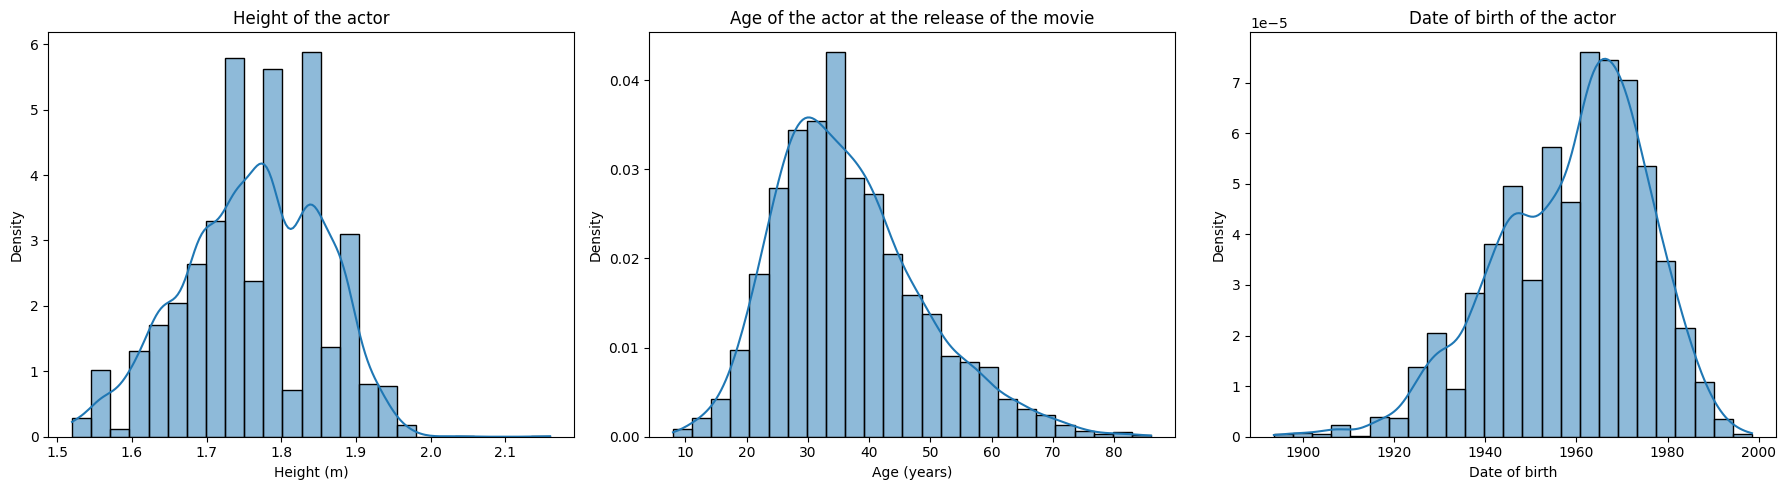

In [109]:
histogram_actors(lead_actors_data_on_subset_movie)

Let's now explore the categorical data.

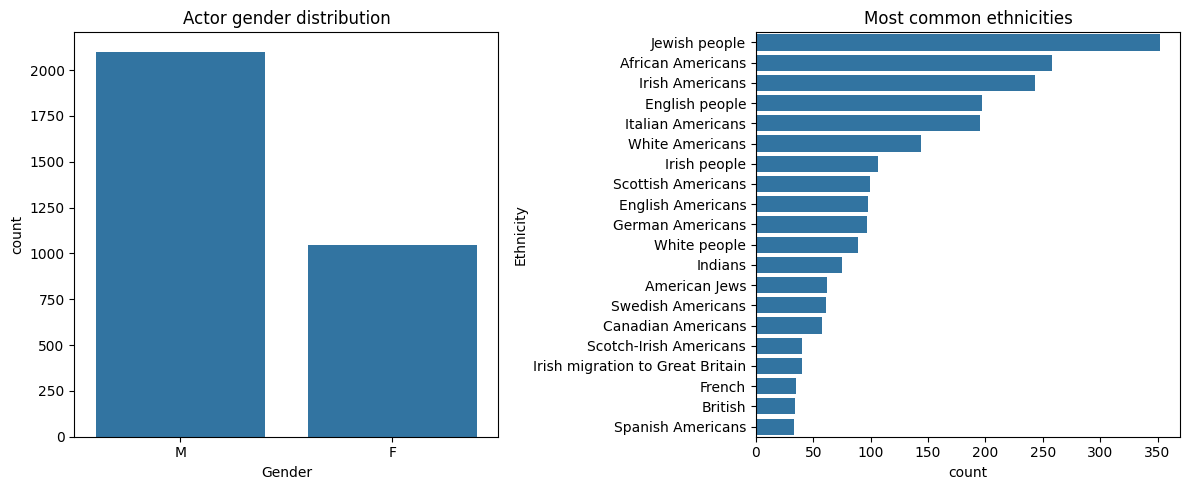

In [110]:
count_actors(lead_actors_data_on_subset_movie)

We can visualize here the correlation matrix between the attributes of the actors.

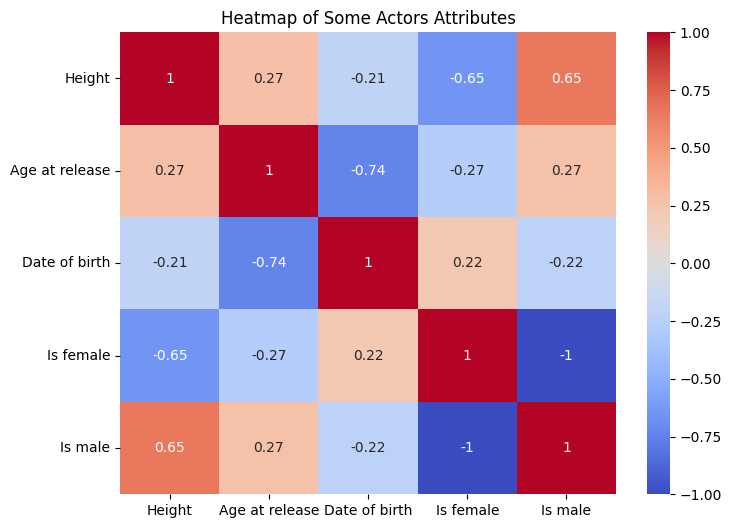

In [111]:

fig, ax = plt.subplots(figsize=(8, 6))

# Subset the data
lead_actors_for_corr = lead_actors_data_on_subset_movie[
    ['actor_height', 'actor_age_at_release', 'actor_dob', 'actor_gender']
]

# Convert gender to boolean using one-hot encoding
lead_actors_gender_dummies = pd.get_dummies(lead_actors_for_corr['actor_gender'], drop_first=False)
lead_actors_for_corr = lead_actors_for_corr.drop('actor_gender', axis=1).join(lead_actors_gender_dummies)

# Compute correlation matrix
corr_matrix = lead_actors_for_corr.corr()

# Define labels for the heatmap
label_names = ['Height', 'Age at release', 'Date of birth', 'Is female', 'Is male']

# Plot heatmap
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names)
ax.set_title('Heatmap of Some Actors Attributes')
plt.show()

### Characters dataset

We now analyze the dataframe with the characters (including non-lead actors). We again start with a summary of the statistics of the numerical features.

In [112]:
characters_data_on_subset_movie.describe()

,actor_dob,actor_height,actor_age_at_release
count,8243,8243.000000,8243.000000
mean,1960-05-11 02:29:53.230619968,1.757668,37.252942
min,1893-02-10 00:00:00,1.510000,5.000000
25%,1949-05-24 00:00:00,1.690000,28.000000
50%,1963-02-17 00:00:00,1.760000,35.000000
75%,1971-09-08 00:00:00,1.830000,45.000000
max,2000-10-31 00:00:00,2.200000,94.000000
std,NaN,0.097180,13.229947


Let's do some plots to visualize better. As it is very similar as the plots from the lead actors dataset, we will compare our plots with the ones from this dataset.

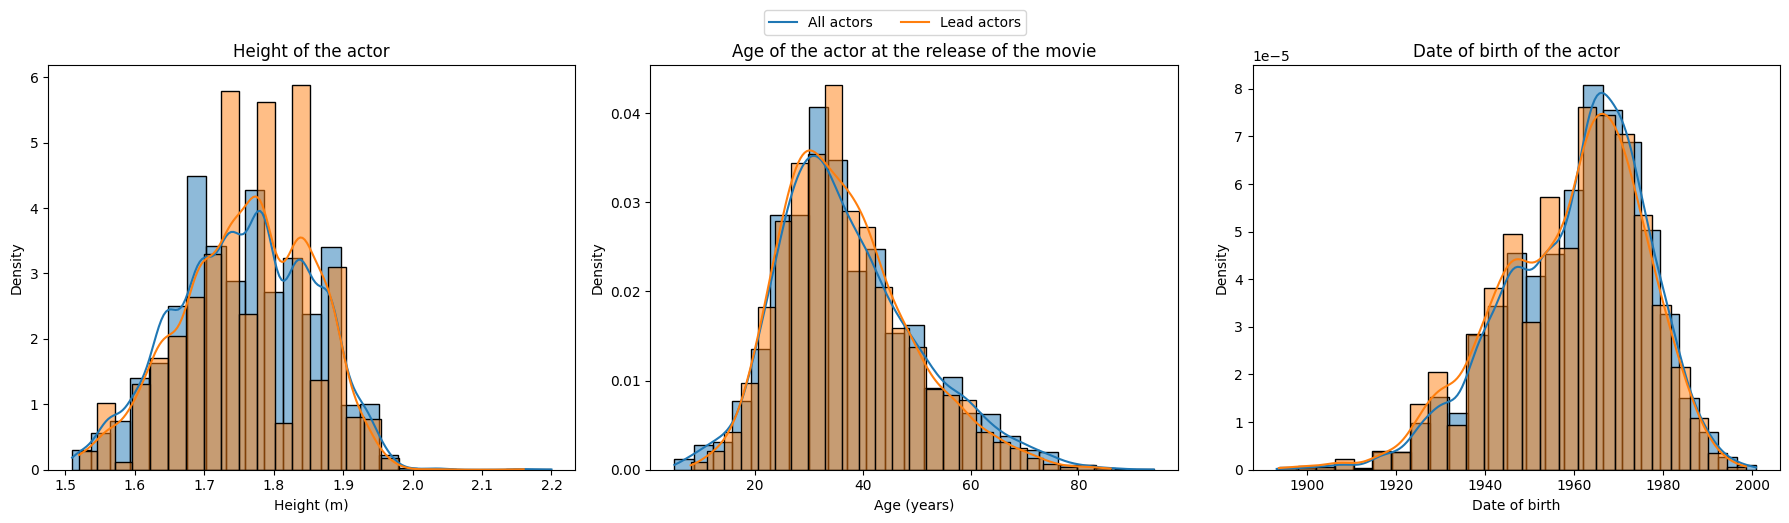

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histogram_actors(characters_data_on_subset_movie, axes=axes)
histogram_actors(lead_actors_data_on_subset_movie, axes=axes)

fig.tight_layout()
fig.legend(["All actors", "Lead actors"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


Finally we compare the gender distribution between all actors and only lead actors.

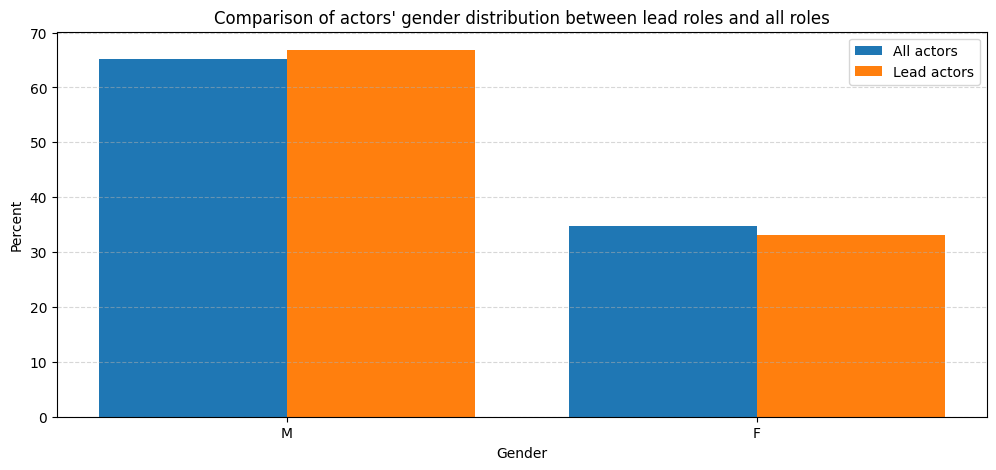

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
width = 0.4

# Compute the distribution
gender_dist_all = characters_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
gender_dist_lead = lead_actors_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
labels = list(gender_dist_all.keys())
# Make the bar plots
bar_all = ax.bar(labels, gender_dist_all, -width, label="All actors", align='edge')
bar_lead = ax.bar(labels, gender_dist_lead, width, label="Lead actors", align='edge')

ax.set_title("Comparison of actors' gender distribution between lead roles and all roles")
ax.set_xlabel("Gender")
ax.set_ylabel("Percent")
plt.grid(axis='y', linestyle='--', alpha=0.5)

ax.legend()
plt.show()

### Movies dataset 

Let's now analyze our movies dataset. We will start with a summary of the statistics of the numerical features.

In [115]:
movie_data_completed = full_movie_data_preprocessed.copy()
movie_data_completed.describe()

,wikipedia_movie_id,movie_release_date,box_office_revenue,runtime,averageRating,numVotes,release_year,adjusted_box_office
count,3.493000e+03,3493,3.493000e+03,3493.000000,3493.000000,3.493000e+03,3493.000000,3.493000e+03
mean,7.225853e+06,1995-05-02 01:52:57.440595456,4.167977e+07,107.578214,6.268394,6.065138e+04,1994.808188,9.074958e+07
min,3.746000e+03,1958-01-29 00:00:00,1.000000e+00,61.000000,1.700000,5.060000e+02,1958.000000,1.913719e+00
25%,1.076567e+06,1987-10-11 00:00:00,4.106588e+06,95.000000,5.700000,5.905000e+03,1987.000000,9.125168e+06
50%,3.058252e+06,1996-10-11 00:00:00,1.471507e+07,104.000000,6.400000,1.850700e+04,1996.000000,3.238625e+07
75%,9.932614e+06,2005-06-10 00:00:00,4.100000e+07,116.000000,6.900000,5.922600e+04,2005.000000,9.459313e+07
max,3.681425e+07,2012-11-02 00:00:00,9.634204e+08,198.000000,8.800000,2.318314e+06,2012.000000,4.022758e+09
std,8.926649e+06,NaN,7.977446e+07,18.176518,0.972713,1.300172e+05,11.856645,1.806332e+08


Let's print their distributions (except for the wikipedia id):

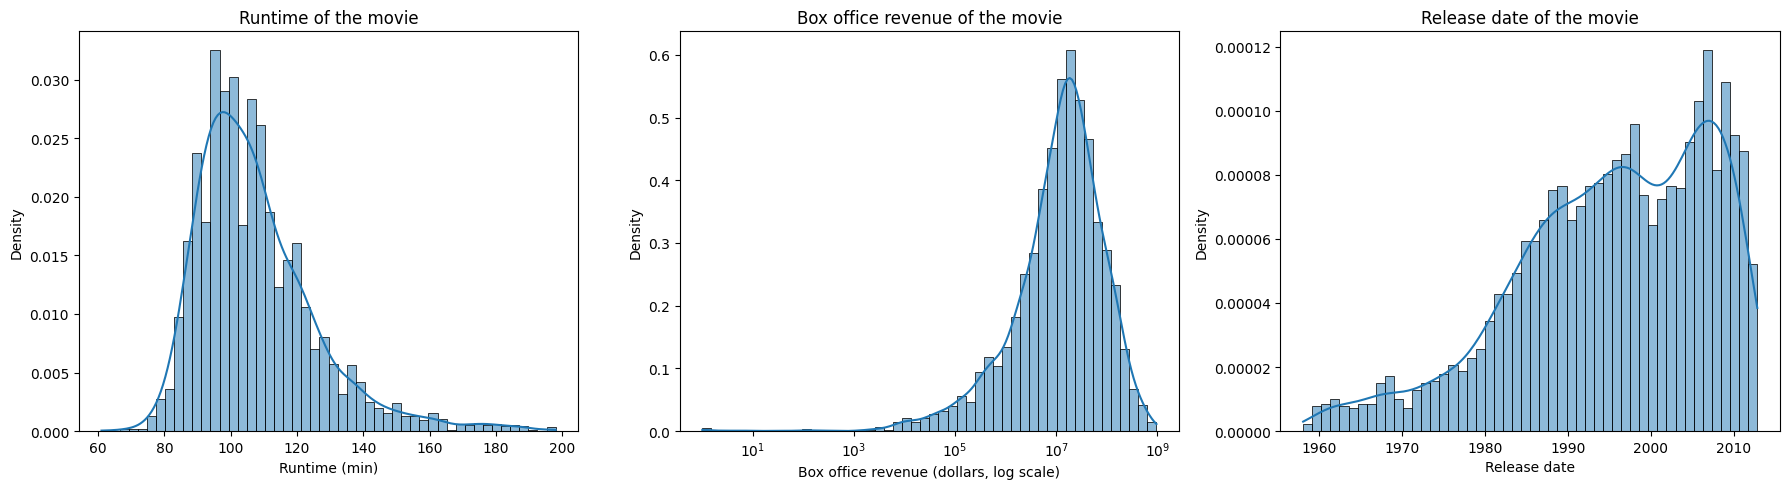

In [116]:
histogram_movies(movie_data_completed)

Let's now look at the ratings and number of votes per movie.

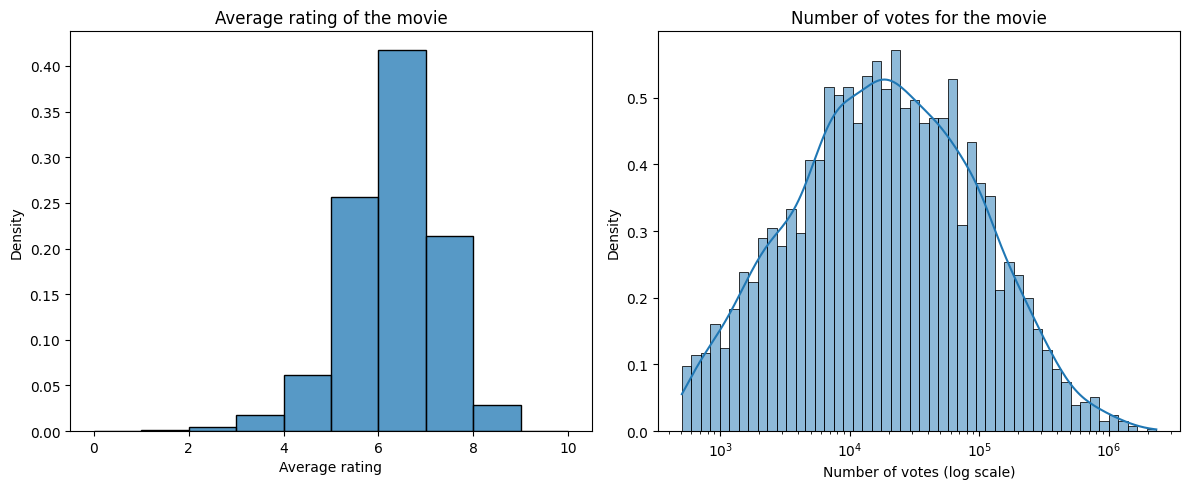

In [117]:
histogram_movie_ratings(movie_data_completed)

We can now have a look at the categorical features:

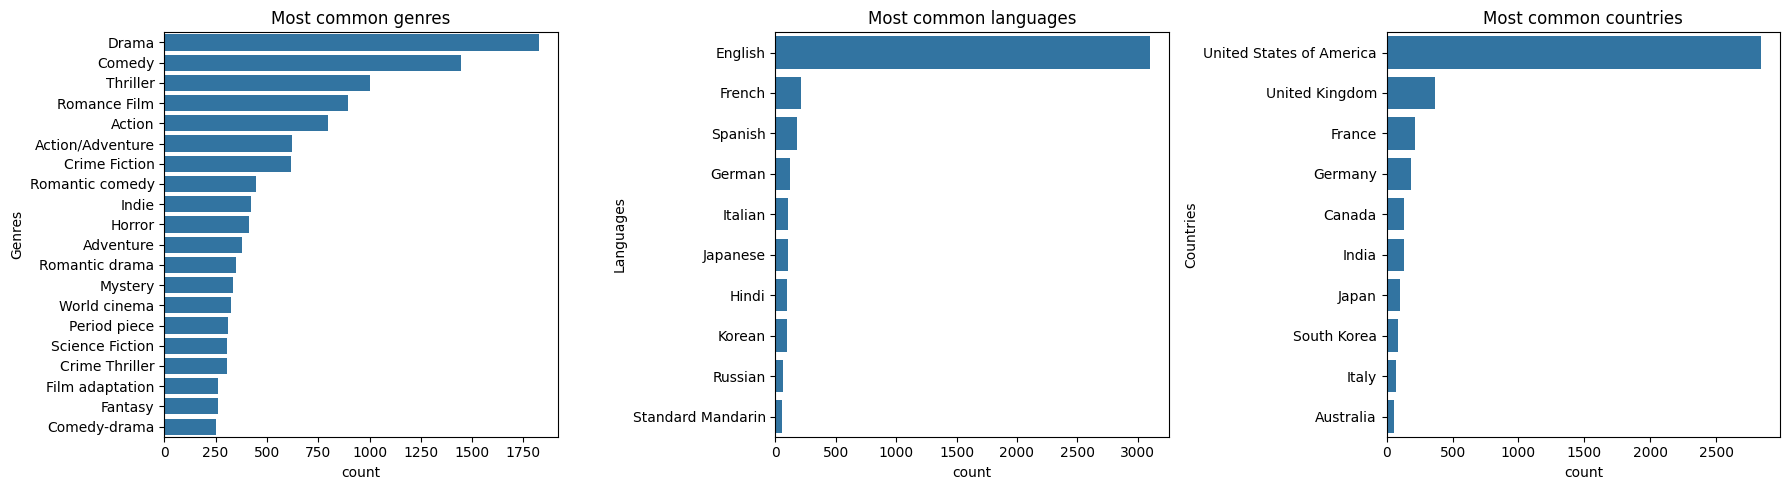

In [118]:
count_movies(movie_data_completed)

As we can expect, the English language and United States of America clearly dominate the movie industry.

## Regression analysis
Let's see if we can predict the box office from the average rating and the number of votes!

In [119]:
# Take the log of the box office revenue and of numVotes
full_movie_data_preprocessed["log_box_office_revenue"] = np.log(full_movie_data_preprocessed["box_office_revenue"])
full_movie_data_preprocessed["log_numVotes"] = np.log(full_movie_data_preprocessed["numVotes"])

In [120]:
# Define the model formula
mod = smf.ols(formula='log_box_office_revenue ~ averageRating + log_numVotes', data=full_movie_data_preprocessed)

# Set a random seed for reproducibility
np.random.seed(0)

# Fit the model
res = mod.fit()

# Print the summary
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     log_box_office_revenue   R-squared:                       0.405
Model:                                OLS   Adj. R-squared:                  0.405
Method:                     Least Squares   F-statistic:                     1190.
Date:                    Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                            21:21:57   Log-Likelihood:                -6701.7
No. Observations:                    3493   AIC:                         1.341e+04
Df Residuals:                        3490   BIC:                         1.343e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

Interesting, there is a strong positive corelation between the number of votes and the box office revenue. Let's visualize this in a scatter plot!

<Axes: xlabel='averageRating', ylabel='log_numVotes'>

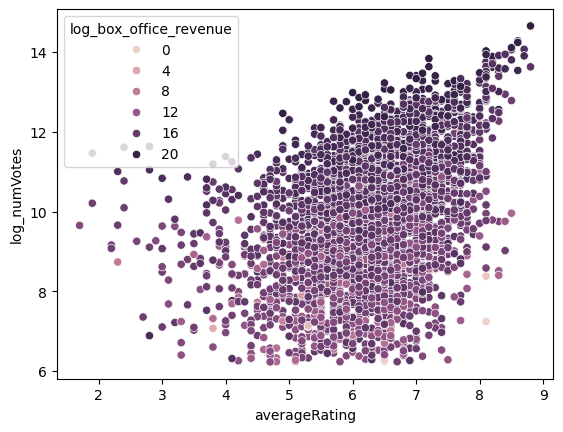

In [121]:
sns.scatterplot(data=full_movie_data_preprocessed, x='averageRating', y='log_numVotes', hue='log_box_office_revenue')

### Inflation Box Office Revenue
We established that the USA is by far the number 1 filmmaker, as such, adjusted box office is indexed on US inflation and given in dollars. We want to see how old movies compare to new movies when levelling the playing field. This can be done through scatterplots of both the average box office return, adjusted for inflation, and the average box office of the ten highest grossing movies in a given year. This is because we may not have information about very old obscure and unsuccessfull movies. By adjusting for inflation, we ensure that our data is not unfairly biaised towards recent releases. 

We start by comparing the mean box office results adjusted/not adjusted for inflation through time.

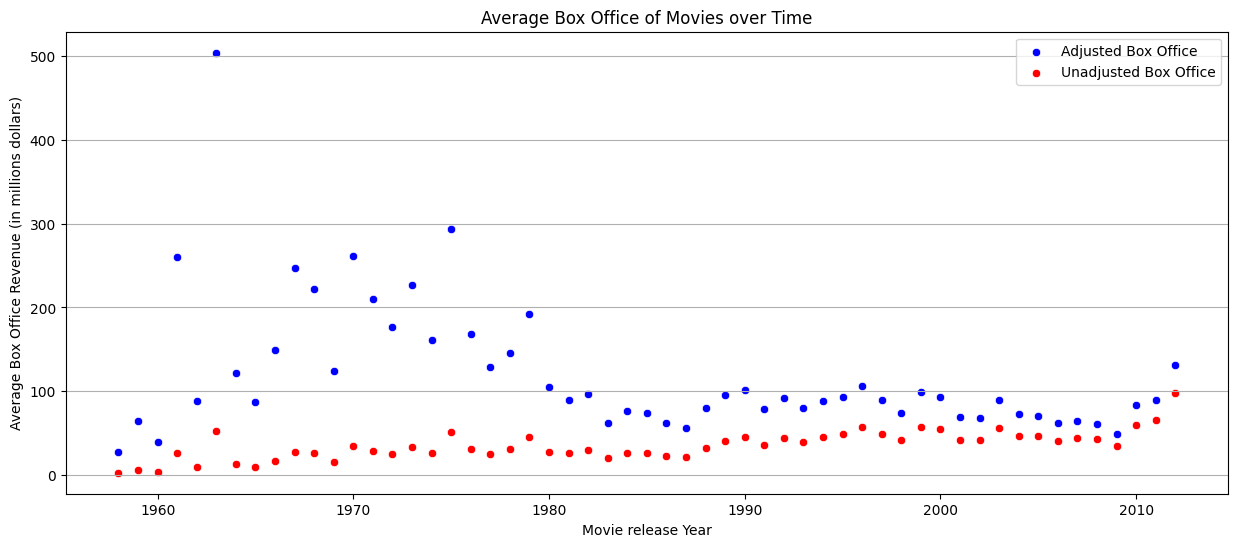

In [122]:
inflation_plots(movie_data_completed)

Interesting, it seems like older movies performed similarily or even better than modern movies when adjusted for inflation.
It could be that we only have data on more successful old movies, and that those that did not perform well were lost to time.
As such, let us test the average box office revenue for the 10 highest grossing movies each year.

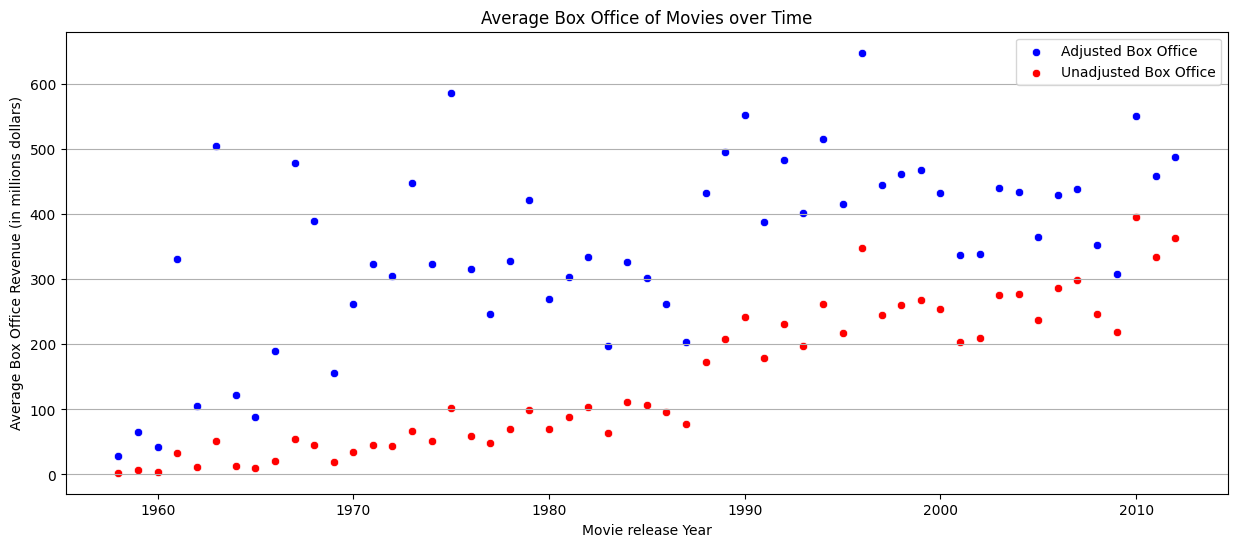

In [123]:
inflation_plots(movie_data_completed, True)

It seems that even adjusted for inflation, box office revenue of the biggest blockbusters are on the rise.

### Low vs. high rating/revenue analysis

Now let's see the difference between low and high rated movies as well as between movies with low and high box office revenues! We will split the dataset by using the median such that we get equals subsets for comparison.

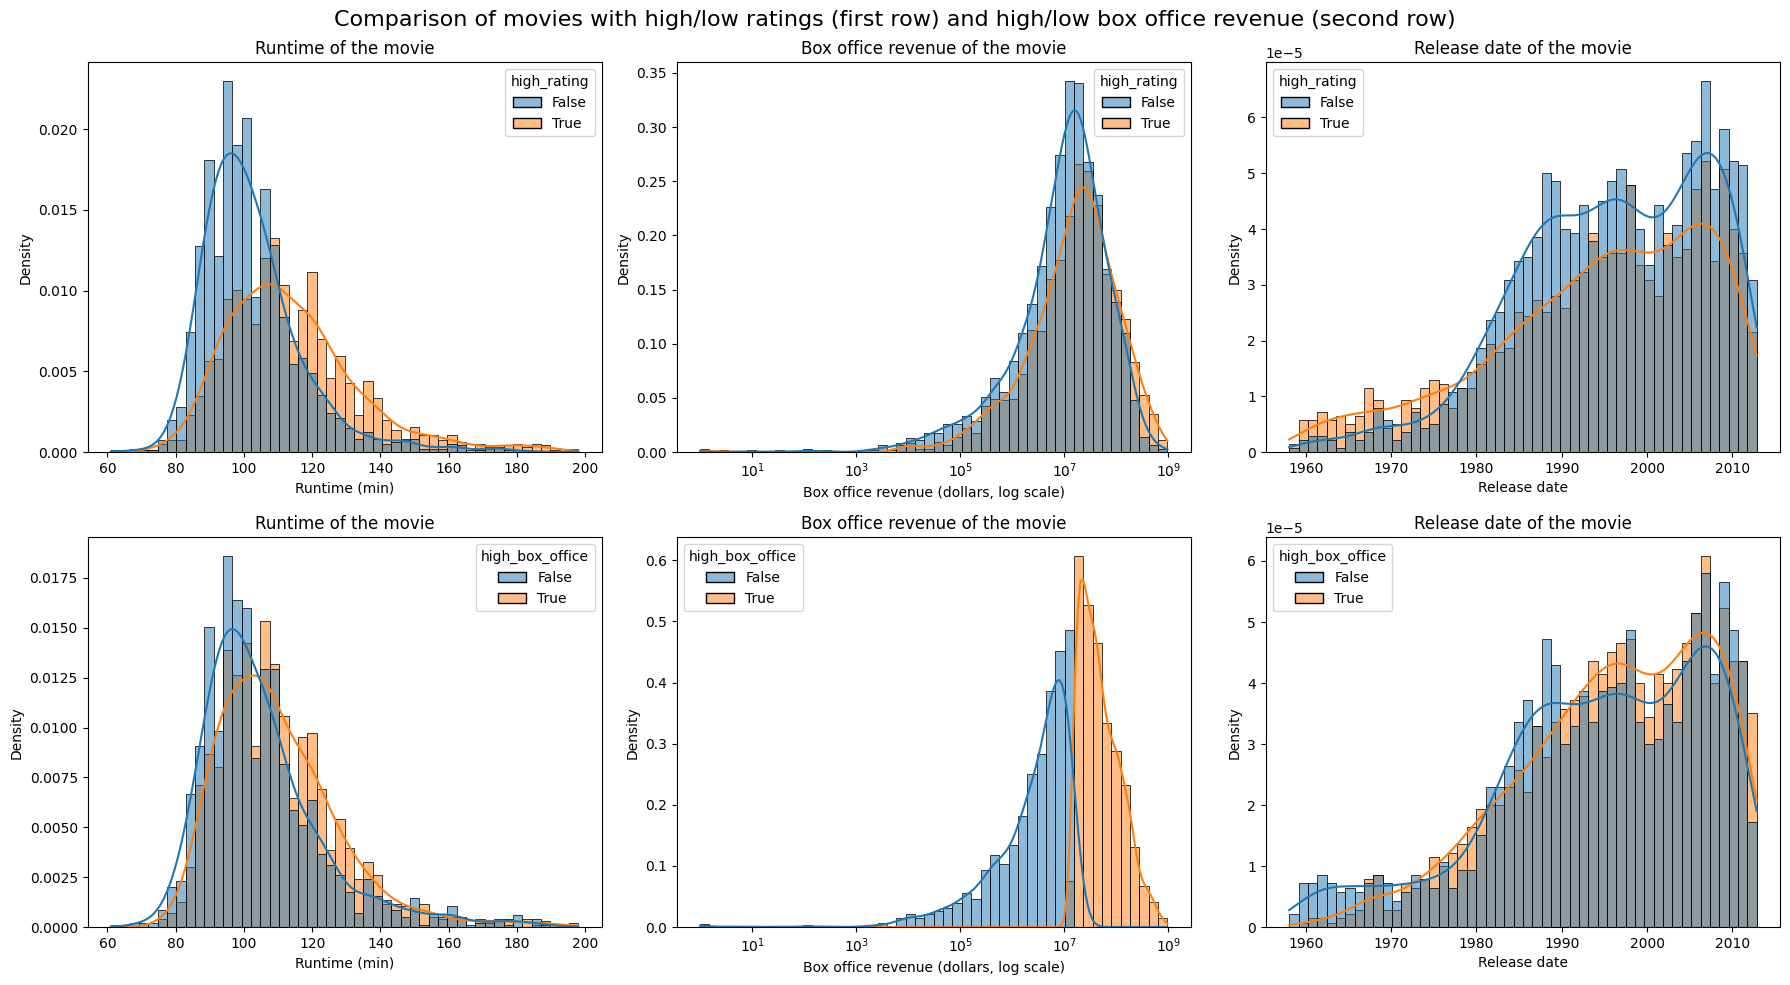

In [124]:
# Split the movies by the median rating and median box office revenue
median_rating = full_movie_data_preprocessed['averageRating'].median()
median_box_office = full_movie_data_preprocessed['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
full_movie_data_preprocessed['high_rating'] = full_movie_data_preprocessed['averageRating'] > median_rating
full_movie_data_preprocessed['high_box_office'] = full_movie_data_preprocessed['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()


First, we see that the box office was correctly split by low/high revenue (see second plot of the second row).

Futhermore, we can observe a slight difference in the runtime distribution between high and low rated/revenue movies.
Let's verify this observation with as statistical test.
From the graph we can see that the data follows a normal distribution.
Therefore, we will make the following null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [125]:

high_rating = full_movie_data_preprocessed['high_rating']
high_box_office = full_movie_data_preprocessed['high_box_office']

runtime = full_movie_data_preprocessed['runtime']

runtime_high_rating_corr = stats.pearsonr(runtime, high_rating)
runtime_high_box_office_corr = stats.pearsonr(runtime, high_box_office)

print(f"Correlation between runtime and high rating: {runtime_high_rating_corr[0]:.3f} (p-value: {runtime_high_rating_corr[1]:.3f})")
print(f"Correlation between runtime and high box office revenue: {runtime_high_box_office_corr[0]:.3f} (p-value: {runtime_high_box_office_corr[1]:.3f})")

Correlation between runtime and high rating: 0.316 (p-value: 0.000)
Correlation between runtime and high box office revenue: 0.129 (p-value: 0.000)


Here our alternative hypothesis is: the correlation is non zero. So our null hypothesis is : the correlation is zero.
Since we have that our p-value < 0.05, we can reject the null hypothesis at 5% significance level and conclude that our high rating and box office revenue are likely correlated with runtime respectively with factors of 0.316 and 0.129.

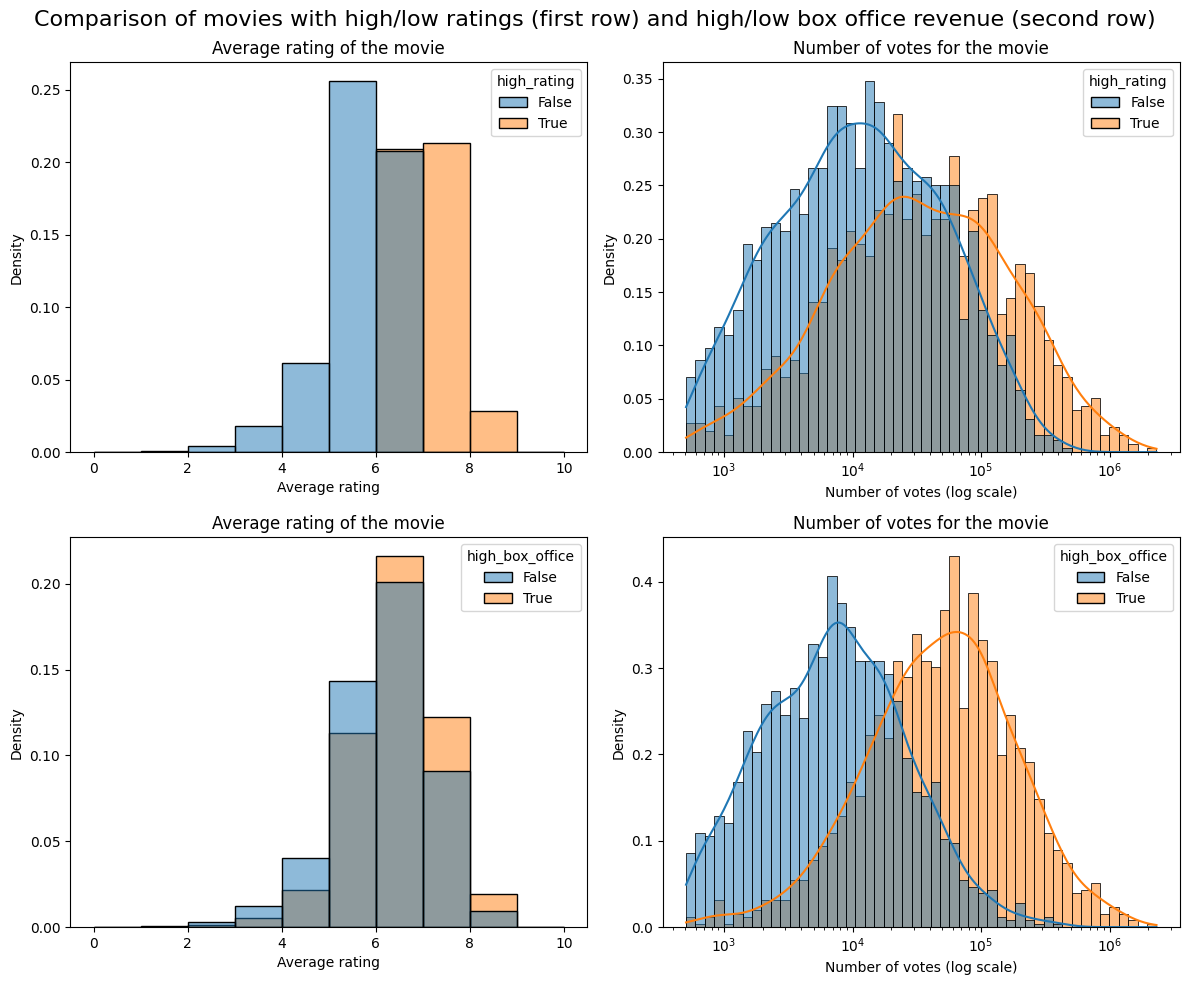

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

histogram_movie_ratings(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movie_ratings(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Again, we see that the data was correctly split by high and low ratings.

Futhermore, we can observe that there is difference in the number of votes for high and low rated/revenue movies.
Let's verify this observation with as statistical test.
From the graph we can see that the data follows a normal distribution.
Therefore, we will make the following null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [127]:
votes = full_movie_data_preprocessed['numVotes']
log_votes = np.log(votes)

log_votes_high_rating_corr = stats.pearsonr(log_votes, high_rating)
log_votes_high_box_office_corr = stats.pearsonr(log_votes, high_box_office)

print(f"Correlation between log votes and high rating: {log_votes_high_rating_corr[0]:.3f} (p-value: {log_votes_high_rating_corr[1]:.3f})")
print(f"Correlation between log votes and high box office revenue: {log_votes_high_box_office_corr[0]:.3f} (p-value: {log_votes_high_box_office_corr[1]:.3f})")

Correlation between log votes and high rating: 0.323 (p-value: 0.000)
Correlation between log votes and high box office revenue: 0.586 (p-value: 0.000)


Here our alternative hypothesis is: the correlation is non zero. So our null hypothesis is : the correlation is zero.
Since we have that our p-value < 0.05, we can reject the null hypothesis at 5% significance level and conclude that our high rating and box office revenue are likely correlated with log votes respectively with factors of 0.323 and 0.586.

Now, let's look at the categorical features.

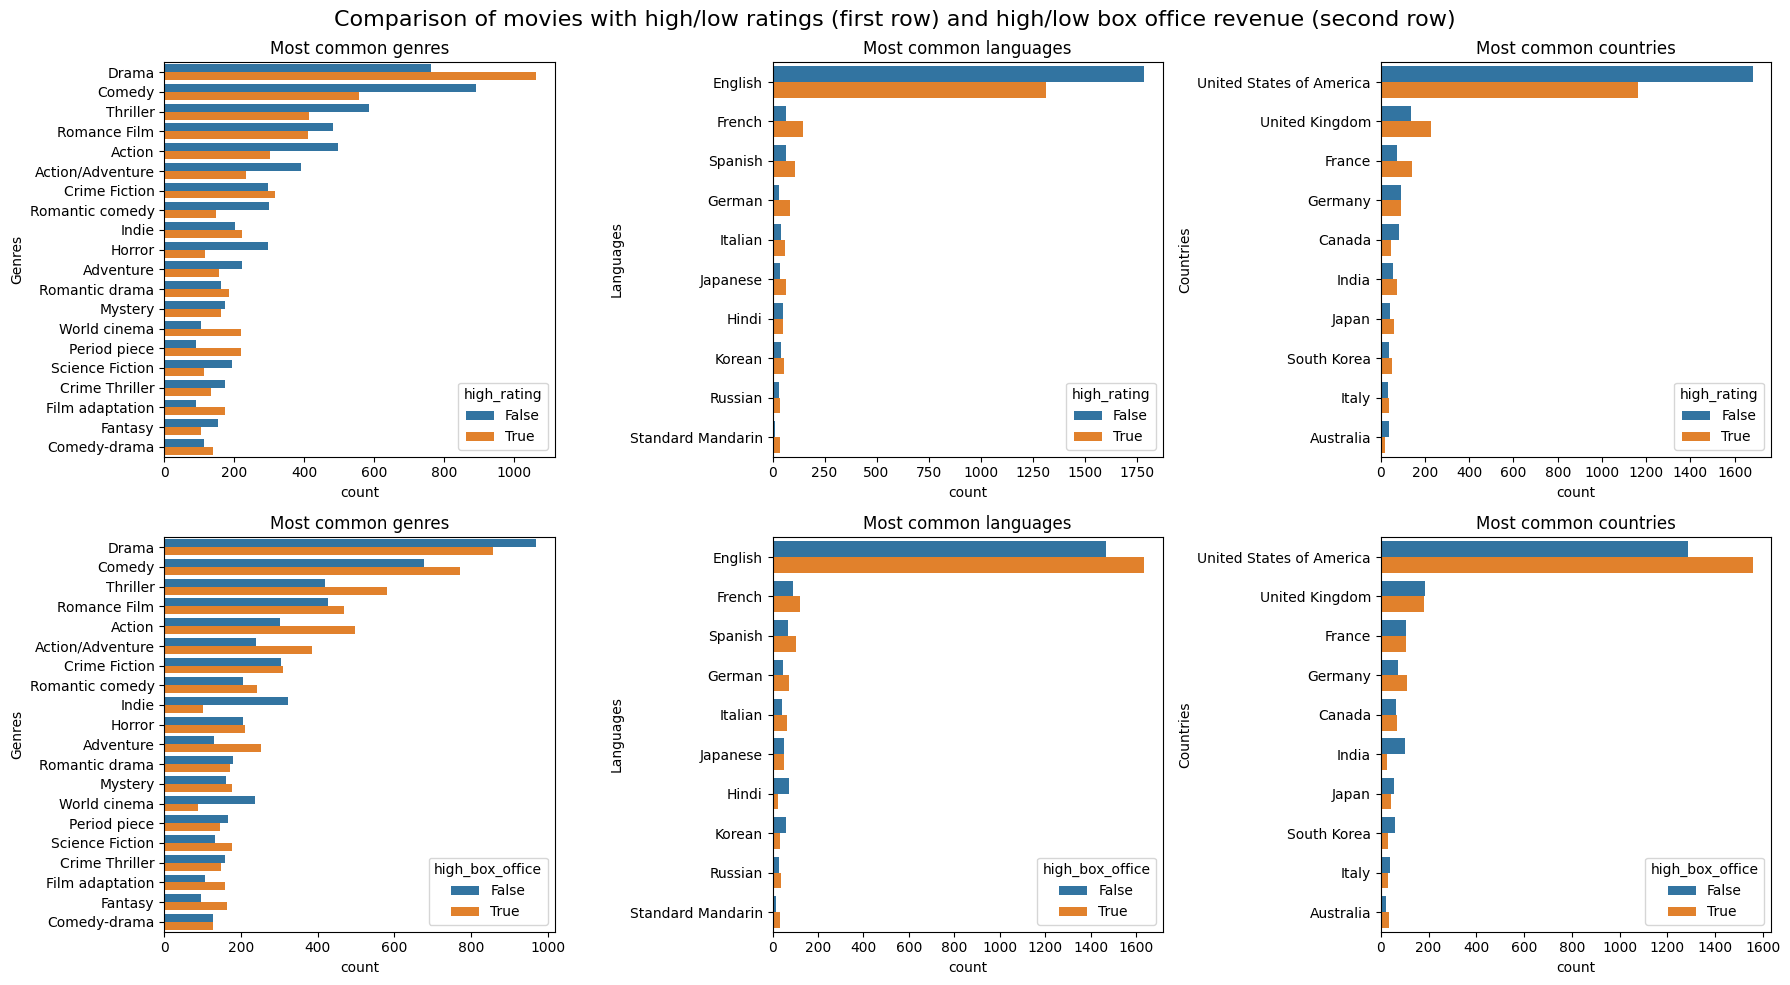

In [128]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

count_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
count_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more higher rated dramas than lower rated one, but there are less high box office revenue dramas than high revenue one.

Futhermore, we see that there are more lower rated comedies but they usually have higher box office revenues.

Now let's have a look at the difference in lead actors' attributes between high and low rating movies.

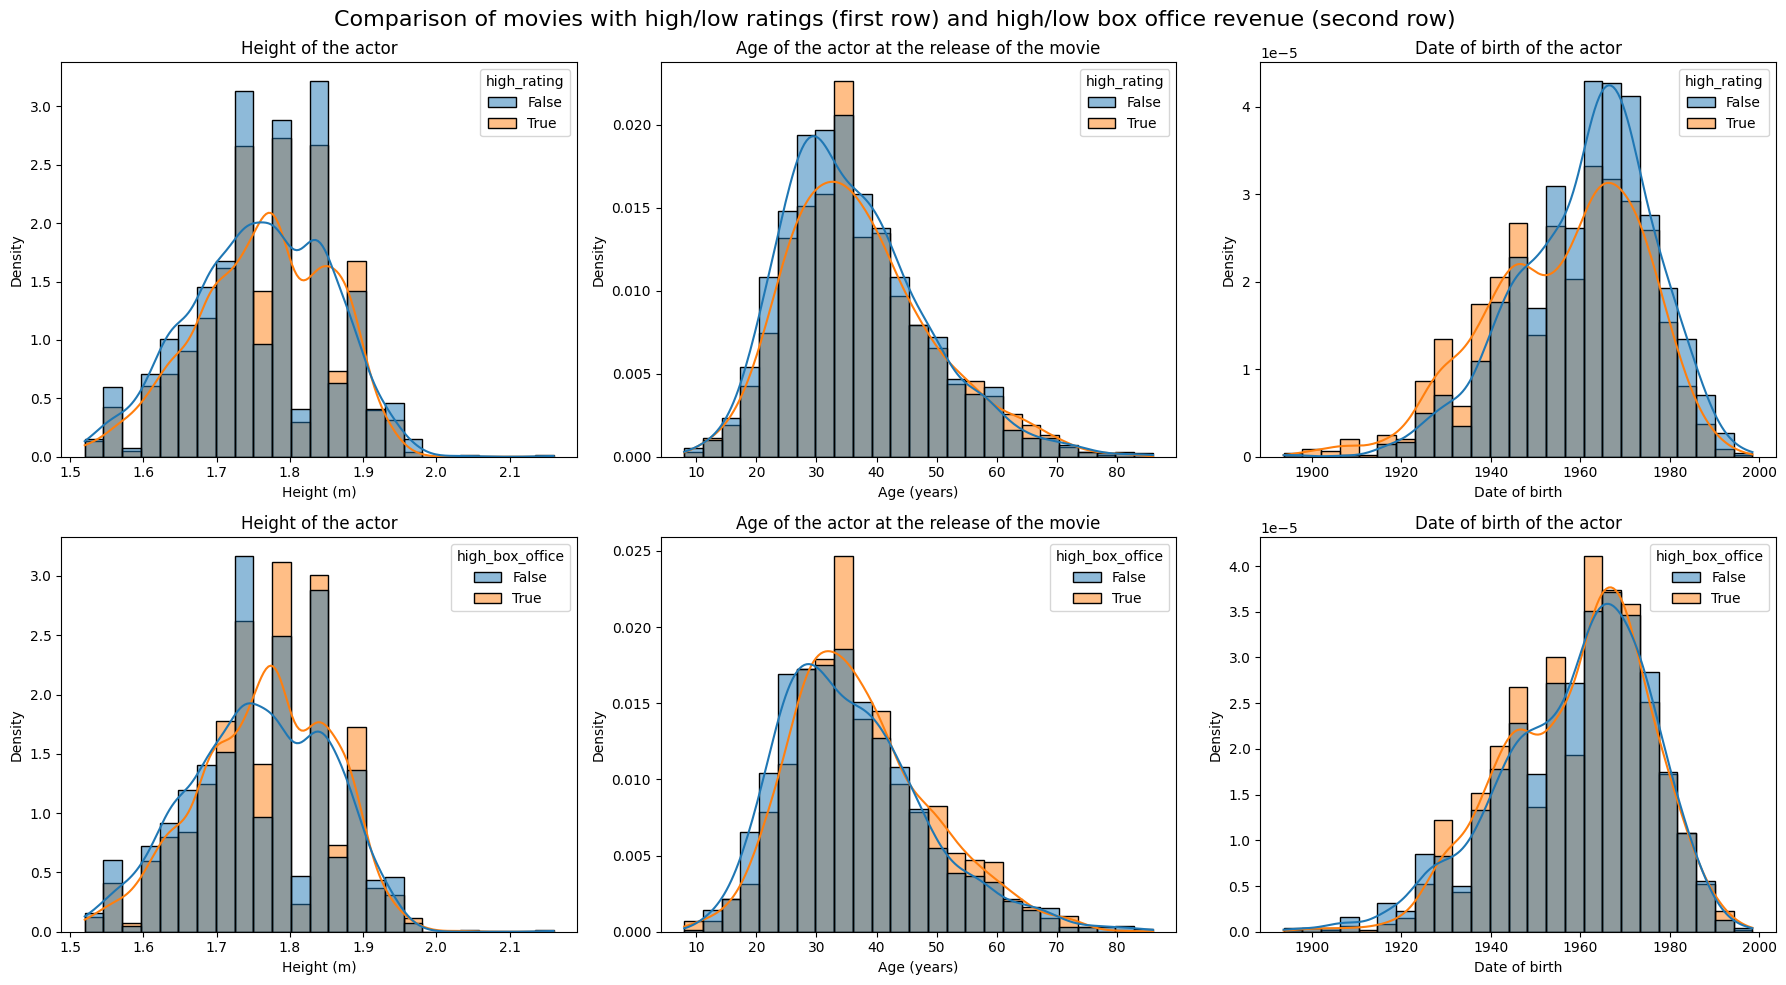

In [129]:
# Merge the movie data with the lead actors data
merged = pd.merge(full_movie_data_preprocessed, lead_actors_data_on_subset_movie, left_on='freebase_movie_id', right_on='freebase_movie_id')

# Split the movies by the median rating and median box office revenue
median_rating = merged['averageRating'].median()
median_box_office = merged['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
merged['high_rating'] = merged['averageRating'] > median_rating
merged['high_box_office'] = merged['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_actors(merged, hue='high_rating', axes=axes[0])
histogram_actors(merged, hue='high_box_office', axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Not much of a difference here, let's look at the categorical attributes.

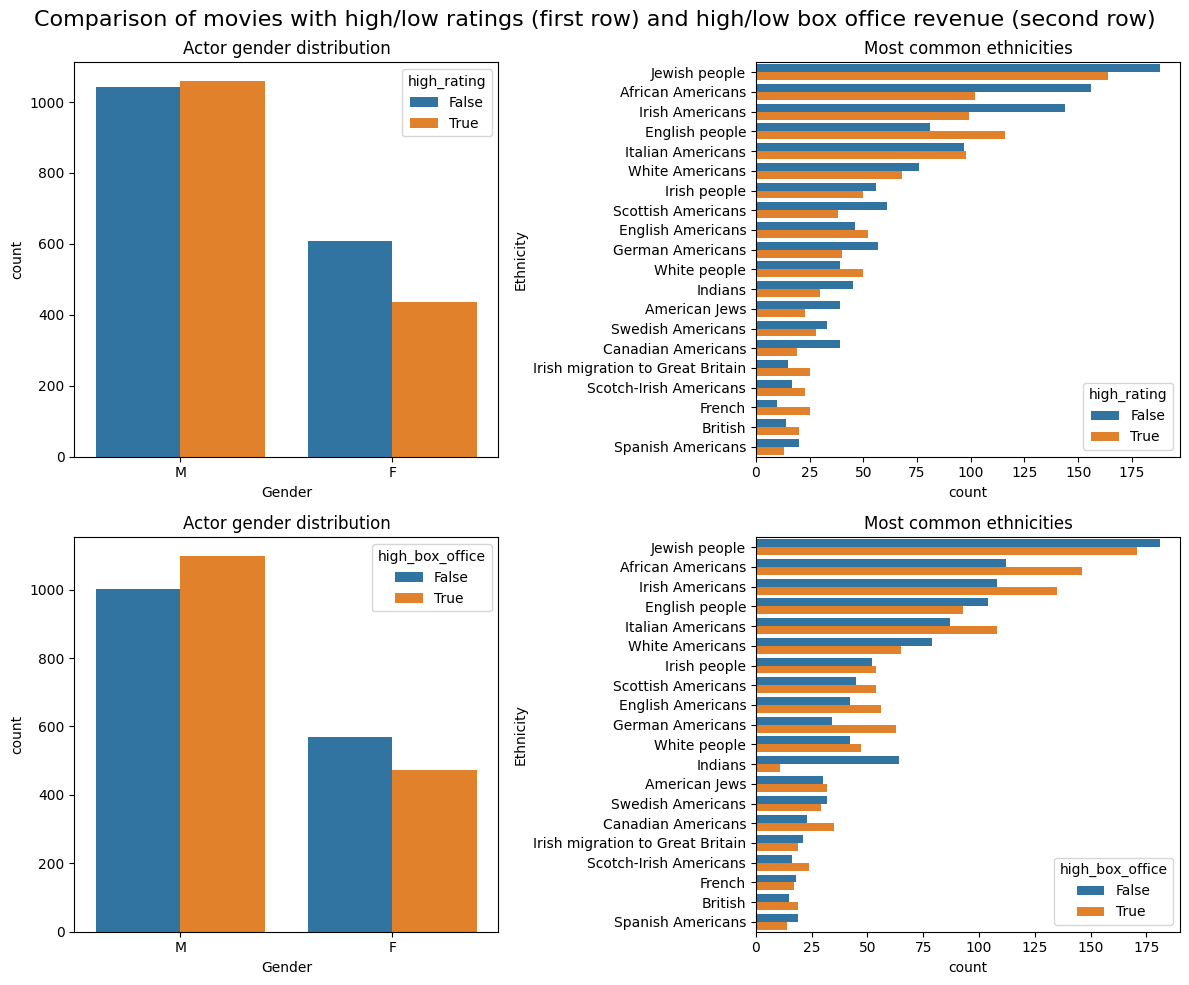

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

count_actors(merged, "high_rating", axes[0])
count_actors(merged, "high_box_office", axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more men in higher rated/revenue movies as in lower rated/revenue movies.
Whereas, it's the opposite for women.
Let's verify this with statistical test!
The null hypothesis is that the frequencies between high/low ratings (and revenues) are independent.

In [131]:
high_rating = merged['high_rating']
high_box_office = merged['high_box_office']

gender = merged['actor_gender'].apply(lambda g: g == 'M')

gender_rating_count = stats.contingency.crosstab(gender, high_rating)
print("Count the number of women/men (rows) with high/low ratings (columns):")
print(gender_rating_count.count)
print()

gender_box_office_count = stats.contingency.crosstab(gender, high_box_office)
print("Count the number of women/men (rows) with high/low box office revenue (columns):")
print(gender_box_office_count.count)

Count the number of women/men (rows) with high/low ratings (columns):
[[ 608  436]
 [1042 1059]]

Count the number of women/men (rows) with high/low box office revenue (columns):
[[ 570  474]
 [1003 1098]]


In [132]:
gender_rating_chi2 = stats.chi2_contingency(gender_rating_count)
gender_box_office_chi2 = stats.chi2_contingency(gender_box_office_count)

# Print the p-values
print(f"Chi-squared test p-value for gender and high rating correlation: {gender_rating_chi2[1]:.3f}")
print(f"Chi-squared test p-value for gneder and high box office revenue correlation: {gender_box_office_chi2[1]:.3f}")

Chi-squared test p-value for gender and high rating correlation: 0.000
Chi-squared test p-value for gneder and high box office revenue correlation: 0.004


In both cases we can reject the null hypothesis by a significance level of 0.05.

Futhermore, we can see that there are more African Americans in lower rated movies as in high rated movies.
Whereas, it's the opposite for English People.

Interestingly, we see that there are more African Americans in movies with high revenue as in lower box office revenue movies.

# Conclusion

Through our deep analysis and comprehensive preprocessing, we are now better equipped to address our research questions. 

The exploratory phase has helped us evaluate the feasibility of our study and ensured the quality and size of our preprocessed dataset. Early analysis of Low vs. High subsets (e.g., high ratings vs. low ratings, high box office revenue vs. low revenue) confirms distinct patterns in genres and runtimes, suggesting these factors are significant for movie success.

Complementary datasets allowed us to determine the lead actors of each movie, opening doors to further analysis on the effect of the main cast. Our pre-processing and analysis helped us to determine that we have a substantial enough dataset of movies and lead actors with non-empty demographic and physical characteristics. Since our project is heavily centered around lead actor characteristics, this was a crucial step in determining that it is indeed feasable.